# Advanced Lane Line Detection

## 0. Required Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import glob
%matplotlib inline

## 1. Camera Calibration

In [2]:
# arrays to store object points(real world) and image points for all the images
objpoints = []
imgpoints = []

nx = 9
ny = 6

objectp = np.zeros((nx * ny, 3), np.float32)

objectp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinates

#convert img into grayscale
#If you are reading in an image using mpimg.imread()
#this will read in an RGB image and you should 
#convert to grayscale using cv2.COLOR_RGB2GRAY
#so we always use cv2.imread()
    
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print(len(images))

# Step through the list and search for chessboard corners
for index, name in enumerate(images):
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objectp)
        imgpoints.append(corners)        

20


## 2. Distortion Correction

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 3. Color and Gradient Threshold

(720, 1280, 3)


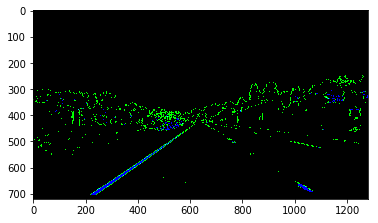

In [4]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def color_gradient_threshold(img, mtx, dist):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary, color_binary


img = cv2.imread('test_images/straight_lines1.jpg')
combined_binary, color_binary = color_gradient_threshold(img, mtx, dist)
print(color_binary.shape)
plt.imshow(combined_binary)
plt.imshow(color_binary)

## 4. Perspective Transform

In [5]:
# Define a function that takes an image,  
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    gray_combined_binary, color_binary = color_gradient_threshold(img, mtx, dist)
    gray = gray_combined_binary
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # Define source points
    src = np.float32([[320,660],[1000,660],[720,470],[570,470]])
    # Define destination points
    dst = np.float32([[250,700],[860,700],[860,100],[250,100]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    # Return the resulting image and matrix    
    return warped, M

(720, 1280)


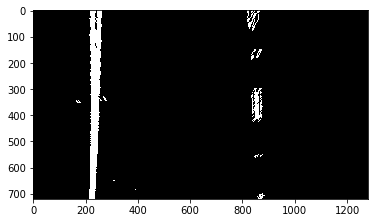

In [6]:
img = cv2.imread('test_images/straight_lines1.jpg')

warped, M = corners_unwarp(img, mtx, dist)
print(warped.shape)
plt.imshow(warped, cmap = 'gray')
#print(warped)

## 6. Find the Lane Lines (polynomial fitting & sliding window)

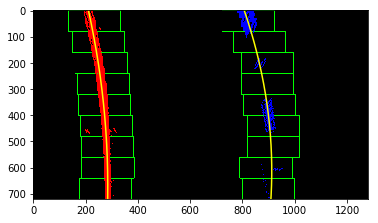

In [7]:
# finding lane line pixels
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # empty list to store the data of previous windows in case there are no good pixels in the window
    prev_good_left_inds = []
    prev_good_right_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        prev_good_left_inds = good_left_inds
        prev_good_right_inds = good_right_inds
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, left_fitx, right_fitx, ploty

img = cv2.imread('test_images/test2.jpg')
warped, M = corners_unwarp(img, mtx, dist)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

plt.imshow(warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped, leftx, lefty, rightx, righty)

plt.imshow(out_img)

## 7. Search Around Poly

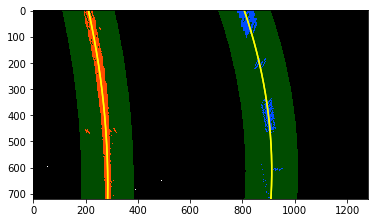

In [8]:
def search_around_poly(binary_warped, leftx, lefty, rightx, righty):
    #left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    final = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return final, left_fit_new, right_fit_new

img = cv2.imread('test_images/test2.jpg')
warped, M = corners_unwarp(img, mtx, dist)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped, leftx, lefty, rightx, righty)

plt.imshow(out_img)
final, left_fit_new, right_fit_new = search_around_poly(warped, left_fit, right_fit, left_fitx, right_fitx)

plt.imshow(final)

## 8. Measure Radius

In [9]:
def measure_curvature_pixels(left_fit, right_fit, binary_warped):
    y_eval = binary_warped.shape[0] # y_eval is the y value at the bottom of the image
    left_curverad = (1 + (2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/(2*left_fit[0]) # left line calculation
    right_curverad = (1 + (2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/(2*right_fit[0]) # right line calculation
    return left_curverad, right_curverad

In [10]:
lr_pix, rr_pix = measure_curvature_pixels(left_fit, right_fit, warped)
print(lr_pix,rr_pix)

-3053.01532241 -1800.8336151


In [11]:
def measure_curvature_real(leftx, rightx, lefty, righty, w):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = w.shape[0]#np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix,2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
    / np.absolute(2*left_fit_cr[0])  # left line 
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) \
    / np.absolute(2*right_fit_cr[0])# right line 
    
    return left_curverad, right_curverad

In [12]:
lr_real, rr_real = measure_curvature_real(leftx, rightx, lefty, righty, warped)
print(lr_real,rr_real)

1002.3907321 588.380928458


## 9. Determine the vehicle position

In [13]:
def vehicle_position(w, left_fit,right_fit):
    y_bottom = w.shape[0]    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    left_bottom = left_fit[0]*y_bottom*y_bottom + left_fit[1]*y_bottom + left_fit[2]
    right_bottom = right_fit[0]*y_bottom*y_bottom + right_fit[1]*y_bottom + right_fit[2]
    lane_center_bottom_in_pixels = np.average([left_bottom,right_bottom])
    lane_center_bottom_in_meters = ((w.shape[1]/2) - lane_center_bottom_in_pixels)*xm_per_pix
    car_position = dict()
    if(lane_center_bottom_in_meters<0):
        car_position['left'] = lane_center_bottom_in_meters
    elif (lane_center_bottom_in_meters==0):
        car_position['center'] = lane_center_bottom_in_meters
    else:
        car_position['right'] = lane_center_bottom_in_meters
    return lane_center_bottom_in_meters

In [14]:
lane_center_in_meters = vehicle_position(warped,left_fit,right_fit)
print(lane_center_in_meters)

0.22877138458


## 10. Display On Image

In [15]:
def display_on_image(w,left_fit,right_fit,M_inv,lr_real,rr_real,lane_center_bottom_real, undist):
    y_values = np.linspace(0, w.shape[0]-1, w.shape[0] )
    left_line = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_line = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    w_zero = np.zeros_like(w).astype(np.uint8)
    color_w = np.dstack((w_zero, w_zero, w_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line, y_values]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line, y_values])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_w, np.int_([pts]), (128,0, 0)) # dark red rgb values (128,0,0)
    warp_to_original = cv2.warpPerspective(color_w, M_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, warp_to_original, 0.3, 0)
    return result

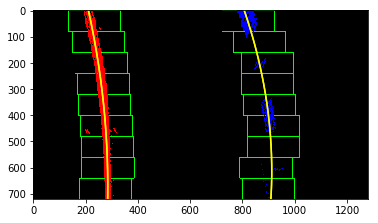

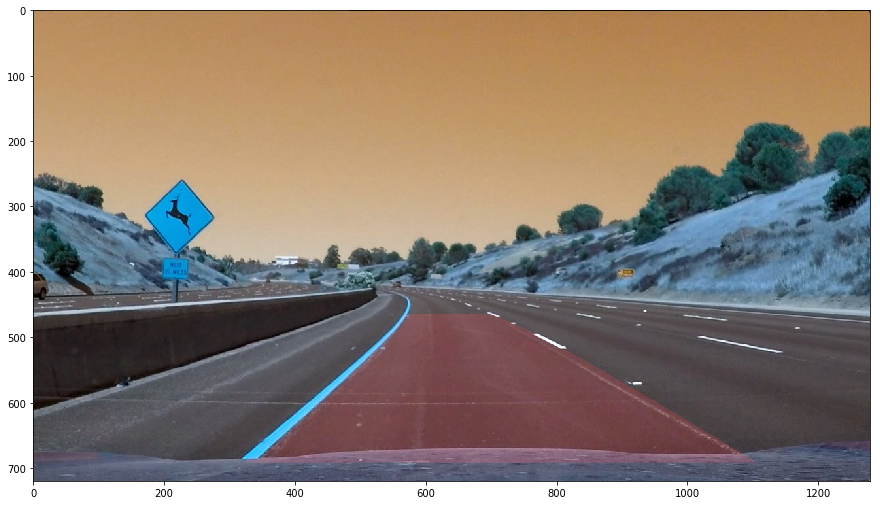

In [16]:
img = cv2.imread('test_images/test2.jpg')
warped, M = corners_unwarp(img, mtx, dist)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped, leftx, lefty, rightx, righty)

plt.imshow(out_img)
final, left_fit_new, right_fit_new = search_around_poly(warped, left_fit, right_fit, left_fitx, right_fitx)

asd = display_on_image(warped,left_fit_new,right_fit_new, np.linalg.inv(M),lr_real,rr_real,lane_center_in_meters, img)
plt.figure(figsize=(15,15))
plt.imshow(asd)

## 11. Corner Cases Whether Both Lines Detected

In [17]:
def is_it_really_a_lane(left_fit, right_fit):
    if len(left_fit) ==0 or len(right_fit) == 0: # if both or any of the left and the right lanes are detected.
        found = False
    else:
        ploty = np.linspace(0, 20, num=10 )      
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        dist_bw_lines = np.mean(right_fitx - left_fitx) # distance between lines detected
        if dist_bw_lines >= 150 and dist_bw_lines <=430: 
            found = True                                # appropriate distance between the detected lines
        else:
            found = False                               # not appropriate distance between the detected lines
        
        slope_l = 2*left_fit[0]*360+left_fit[1]       # check slope at the middle of the lane to check if parallel
        slope_r = 2*right_fit[0]*360+right_fit[1]
        difference_in_slope =  np.abs(slope_l-slope_r)
        
        if difference_in_slope <= 0.15: # if the difference in slope is less than 0.1, the lines are more or less parallel
            found = True
        else:
            found = False
    return found

In [18]:
class Line():
    def __init__(self):
        self.detected = False    # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None        # average x values of the fitted line over the last n iterations
        self.best_fit = None     # polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None  # radius of curvature of the line in some units
        self.line_base_pos = None  # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float')  # difference in fit coefficients between last and new fits
        #self.allx = None         # x values for detected line pixels
        #self.ally = None         # y values for detected line pixels
        self.count = 0
        self.reset_count = 0
        self.prev_left = None
        self.prev_right = None
        self.left_fit = None
        self.right_fit = None
        self.left_lane = []
        self.right_lane = []
    def add_lane(self, left, right):
        self.left_lane.append(left)
        self.right_lane.append(right)

l = Line()


## 12. PipeLine Final

In [31]:
def process_image(img):
    warped, M = corners_unwarp(img, mtx, dist)

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped, leftx, lefty, rightx, righty)

    final, left_fit_new, right_fit_new = search_around_poly(warped, left_fit, right_fit, left_fitx, right_fitx)

    #asd = display_on_image(warped,left_fit_new,right_fit_new, np.linalg.inv(M),lr_real,rr_real,lane_center_in_meters, img)
    #plt.figure(figsize=(15,15))
    
    if l.count == 0:
        l.left_fit = left_fit
        l.right_fit = right_fit
    else:
        result, A, B = search_around_poly(warped, left_fit, right_fit, left_fitx, right_fitx)
        l.left_fit = A
        l.right_fit = B
    found_lane = is_it_really_a_lane(l.left_fit, l.right_fit)
    if found_lane == True:
        l.prev_left = l.left_fit
        l.prev_right = l.right_fit
        l.reset_count = 0
    else:
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped, leftx, lefty, rightx, righty)    
        if l.count > 4:
            l.left_fit = left_fit
            l.right_fit = right_fit
            l.reset_count = 0
        else:
            l.left_fit = l.prev_left
            l.right_fit = l.prev_right
            l.count += 1 
    lr_pix, rr_pix = measure_curvature_pixels(left_fit,right_fit, warped)
    lr_real, rr_real = measure_curvature_real(leftx,rightx,lefty,righty, warped)
    lane_center_in_meters = vehicle_position(warped,left_fit,right_fit)
    final_output_img = display_on_image(warped,left_fit,right_fit,np.linalg.inv(M) ,lr_real,rr_real,lane_center_in_meters,img)
    cv2.putText(final_output_img, 'Left Lane Radius: {:.0f} m'.format(lr_real), (800, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_output_img, 'Right Lane Radius: {:.0f} m'.format(rr_real), (800, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_output_img, 'Vehicle Position: {:.2f} m'.format(lane_center_in_meters), (800, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    #plt.imshow(final_output_img)
    return final_output_img

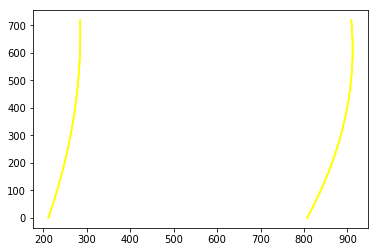

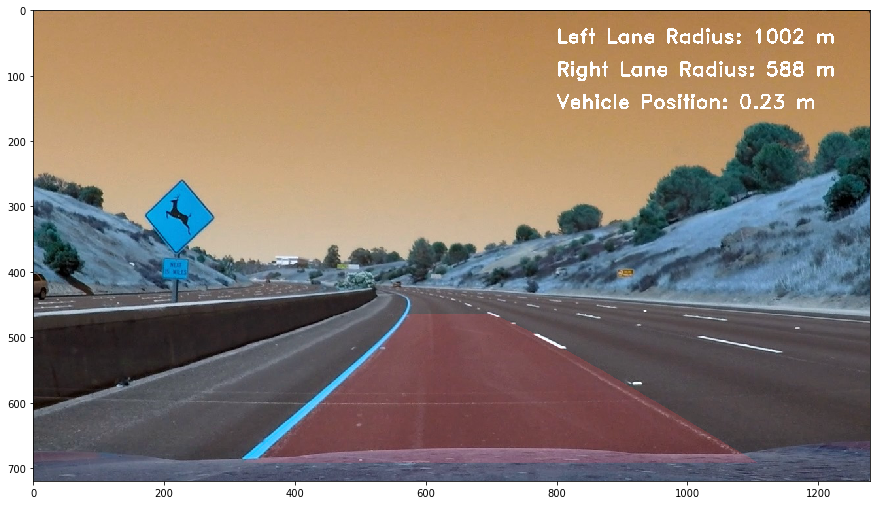

In [32]:
img = cv2.imread('test_images/test2.jpg')
FINAL = process_image(img)
plt.figure(figsize=(15,15))
plt.imshow(FINAL)

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



 12%|█▏        | 152/1261 [00:45<05:52,  3.15it/s]


 24%|██▍       | 303/1261 [01:34<05:03,  3.16it/s]


 36%|███▌      | 454/1261 [02:23<04:28,  3.00it/s]


 48%|████▊     | 605/1261 [03:15<03:41,  2.96it/s]


 60%|█████▉    | 756/1261 [04:08<02:57,  2.85it/s]


 72%|███████▏  | 907/1261 [05:03<02:19,  2.54it/s]


 84%|████████▍ | 1057/1261 [06:01<01:24,  2.41it/s]


 96%|█████████▌| 1205/1261 [07:03<00:22,  2.46it/s]


100%|█████████▉| 1260/1261 [07:26<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 5min 5s, sys: 6.22 s, total: 5min 11s
Wall time: 7min 29s


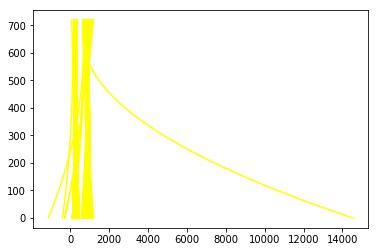

In [34]:
abcwhite_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(abcwhite_output, audio=False)

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(abcwhite_output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 27%|██▋       | 133/485 [00:38<01:48,  3.26it/s]

TypeError: expected non-empty vector for x

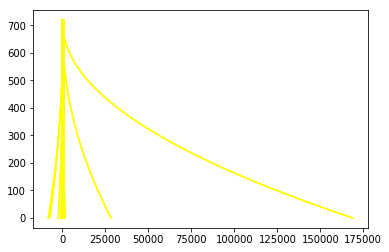

In [36]:
challenge_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(challenge_output, audio=False)

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))